In [1]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12310781627484430270
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13447495313469604176
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [3]:
# DeepFashion Dataset Path
dataset_path = '/data/Deepfashion'
train_path = dataset_path + '/train'
validation_path = dataset_path + '/validation'
test_path = dataset_path + '/test'

In [4]:
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 10
category_nums = 22
drop_rate = 0.2
learning_rate = 0.001
momentum_num = 0.99

In [5]:
train_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demotrain-Copy1.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,8816,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
1,8817,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
2,8818,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
3,8819,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer
4,8820,/data/Deepfashion/train/Blazer/Longline_Side-S...,Blazer


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_train
)

Found 44000 validated image filenames belonging to 22 classes.


In [7]:
category_nums = {}

print(train_generator.filenames[0].split('/')[4])

for filename in train_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print(category_nums)
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
{'Blazer': 1999, 'Blouse': 1999, 'Cardigan': 1999, 'Coat': 1999, 'Cutoffs': 1999, 'Dress': 1999, 'Hoodie': 1999, 'Jacket': 1999, 'Jeans': 1999, 'Joggers': 1999, 'Jumpsuit': 1999, 'Leggings': 1999, 'Parka': 1999, 'Romper': 1999, 'Shirts': 1999, 'Shorts': 1999, 'Skirt': 1999, 'Sweater': 1999, 'Tank': 1999, 'Tee': 1999, 'Top': 1999, 'Trunks': 1999}
[('Blazer', 1999), ('Blouse', 1999), ('Cardigan', 1999), ('Coat', 1999), ('Cutoffs', 1999), ('Dress', 1999), ('Hoodie', 1999), ('Jacket', 1999), ('Jeans', 1999), ('Joggers', 1999), ('Jumpsuit', 1999), ('Leggings', 1999), ('Parka', 1999), ('Romper', 1999), ('Shirts', 1999), ('Shorts', 1999), ('Skirt', 1999), ('Sweater', 1999), ('Tank', 1999), ('Tee', 1999), ('Top', 1999), ('Trunks', 1999)]
43978


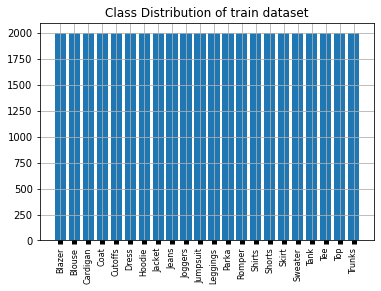

In [8]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [9]:
validation_csv_path = '/home/azure/passion/AI/Demo/sampling_dataframe/demovalidation-Copy1.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,640,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
1,641,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
2,642,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
3,643,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer
4,644,/data/Deepfashion/validation/Blazer/Dropped_La...,Blazer


In [10]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(img_row, img_col),
    batch_size=batch_size_validation
)

Found 8801 validated image filenames belonging to 22 classes.


In [11]:
category_nums = {}

print(validation_generator.filenames[0].split('/')[4])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[4]
    if class_name not in category_nums:
        category_nums[class_name] = 0
    else:
        category_nums[class_name] += 1


print(category_nums)       
print(sorted(category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(category_nums.values()))

Blazer
{'Blazer': 399, 'Blouse': 399, 'Cardigan': 399, 'Coat': 399, 'Cutoffs': 399, 'Dress': 399, 'Hoodie': 399, 'Jacket': 399, 'Jeans': 398, 'Joggers': 400, 'Jumpsuit': 399, 'Leggings': 399, 'Parka': 400, 'Romper': 399, 'Shirts': 399, 'Shorts': 399, 'Skirt': 399, 'Sweater': 399, 'Tank': 399, 'Tee': 399, 'Top': 399, 'Trunks': 399}
[('Joggers', 400), ('Parka', 400), ('Blazer', 399), ('Blouse', 399), ('Cardigan', 399), ('Coat', 399), ('Cutoffs', 399), ('Dress', 399), ('Hoodie', 399), ('Jacket', 399), ('Jumpsuit', 399), ('Leggings', 399), ('Romper', 399), ('Shirts', 399), ('Shorts', 399), ('Skirt', 399), ('Sweater', 399), ('Tank', 399), ('Tee', 399), ('Top', 399), ('Trunks', 399), ('Jeans', 398)]
8779


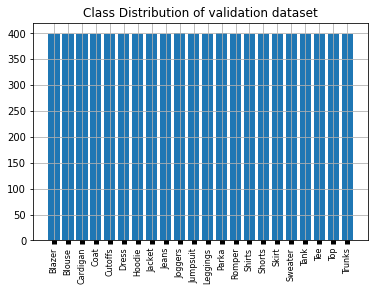

In [12]:
fig, ax = plt.subplots()
plt.bar(list(category_nums.keys()), category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [13]:
class_labels_sampling = list(train_generator.class_indices.keys())
print("class labels sampling keys: ", class_labels_sampling)
print("The number of class labels: ", len(class_labels_sampling))
num_imgs_train_sampling = len(train_generator.filenames)
print("The number of train images sampling: ", num_imgs_train_sampling)
num_imgs_validation_sampling = len(validation_generator.filenames)
print("The number of validation images sampling: ", num_imgs_validation_sampling)

class labels sampling keys:  ['Blazer', 'Blouse', 'Cardigan', 'Coat', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit', 'Leggings', 'Parka', 'Romper', 'Shirts', 'Shorts', 'Skirt', 'Sweater', 'Tank', 'Tee', 'Top', 'Trunks']
The number of class labels:  22
The number of train images sampling:  44000
The number of validation images sampling:  8801


In [17]:
# Initialize the Resnet50 model
resnet50_conv = ResNet50(
    weights='imagenet',
    input_shape=(img_row, img_col, img_channel),
    include_top=False,
    pooling='avg'
)

for layer in resnet50_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in resnet50_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7fcc4b6f60> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f7fcc130e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fcc0fe358> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7fcc0de438> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fcc122c18> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f7fcc130cf8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7fcc130198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fcc213a90> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7fcc1e76a0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7f7fcc159be0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7fcc130fd0> False
<tensorflow.python.keras.laye

In [18]:
# ResNet50
x = resnet50_conv.output
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
y = Dense(22, activation='softmax')(x)

model = Model(inputs=resnet50_conv.input,
             outputs=[y])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Demo/output/model_summary/resnet50_small_model1.jpg')

In [21]:
opt = SGD(lr=0.0001, momentum=0.9, nesterov=True)

In [22]:
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

In [23]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    top_5_categorical_accuracy = model_histories.history['top_k_categorical_accuracy']
    val_acc = model_histories.history['val_accuracy']
    val_top_5_categorical_accuracy = model_histories.history['val_top_k_categorical_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_small_model_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_small_model_loss.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_5_categorical_accuracy, 'mo', label='Training top 5 categorical accuracy')
    plt.plot(range(epochs), val_top_5_categorical_accuracy, 'b', label='Validation top 5 categorical accuracy')
    plt.title('Training and validation top 5 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Demo/output/plot/resnet50_small_model_top_5_accuracy.jpg')
    plt.show()

In [24]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Demo/output/csv_logger/resnet50_small_model.csv'
    csv_log = tf.keras.callbacks.CSVLogger(
        filename, 
        separator=' ', 
        append=False
    )
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=100, 
        verbose=1, 
        mode='min'
    )
    
    # ReduceLRonPlateau
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=15,
        factor=0.5,
        verbose=1
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Demo/output/checkpoint/resnet50_small_model.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, lr_reducer, check_point]
    return callback_list

In [25]:
callback_list = callback()

In [26]:
def fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=num_imgs_train_sampling//batch_size_train,
        validation_data=validation_generator,
        validation_steps=num_imgs_validation_sampling//batch_size_validation,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

In [27]:
model, history, score = fit_model(model, train_generator, validation_generator, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))
print('Validation Top 5 categorical accuracy: {}'.format(score[5]))
# Model Save
model.save('/home/azure/passion/AI/Demo/output/resnet_small_model.h5')

Epoch 1/10
687/687 [==============================] - 358s 498ms/step - loss: 3.8659 - accuracy: 0.1041 - top_k_categorical_accuracy: 0.3712 - val_loss: 3.6398 - val_accuracy: 0.1640 - val_top_k_categorical_accuracy: 0.5149
Epoch 2/10
687/687 [==============================] - 337s 491ms/step - loss: 3.5259 - accuracy: 0.2136 - top_k_categorical_accuracy: 0.5781 - val_loss: 3.4459 - val_accuracy: 0.2127 - val_top_k_categorical_accuracy: 0.6032
Epoch 3/10
687/687 [==============================] - 339s 494ms/step - loss: 3.2959 - accuracy: 0.2685 - top_k_categorical_accuracy: 0.6584 - val_loss: 3.2846 - val_accuracy: 0.2497 - val_top_k_categorical_accuracy: 0.6474
Epoch 4/10
687/687 [==============================] - 338s 492ms/step - loss: 3.1220 - accuracy: 0.3073 - top_k_categorical_accuracy: 0.7036 - val_loss: 3.2708 - val_accuracy: 0.2440 - val_top_k_categorical_accuracy: 0.6352
Epoch 5/10
687/687 [==============================] - 337s 491ms/step - loss: 2.9779 - accuracy: 0.3442 

KeyboardInterrupt: 

In [28]:
model.load_weights('/home/azure/passion/AI/Demo/output/checkpoint/resnet50_small_model.ckpt')
evaluation = model.evaluate(validation_generator)
print(evaluation)

138/138 [==============================] - 27s 194ms/step - loss: 3.1313 - accuracy: 0.2732 - top_k_categorical_accuracy: 0.6845
[3.131301164627075, 0.273150771856308, 0.6844676733016968]
